<a href="https://colab.research.google.com/github/juliaplazari/EA-619/blob/main/Exp3/Exp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 3 - EA619

## Alunos:
Júlia Perassolli De Lázari -
Turma K

RA: 200298

Vídeo: https://drive.google.com/file/d/1-bIyZTaANjXIsoFI1eJZWsOUriPowyCS/view?usp=sharing

Thiago Soares Laitz -
Turma S

RA: 224898

Vídeo: https://drive.google.com/file/d/15MnB6634L6jozn0_2LVoueV3-0GLG9U5/view?usp=sharing

## Objetivo

O objetivo desse experimento foi criar um simulador para notas musicais, no caso, notas de um violão.

O som sintetizado foi de uma nota lá com frequência 110Hz. Para isso utilizamos o sistema descrito por K. Karplus e A. Strong.
 


## Parte teórica

### Base teórica

O sistema Karplus-Strong usa o seguinte modelo:

<img src=https://slipechodotcom.files.wordpress.com/2016/09/synthesizing-plunk-01.jpg>


O feedback modela o fato de que a energia trafega na corda de um lado para o outro, retornando periodicamente, após o atraso de $N$ amostras, até o ponto onde ela foi tocada. É esta característica periódica, controlada pelo tamanho do atraso, que nos permite escolher qual a frequência da nota será tocada. É possível interpretar o modelo como uma solução aproximada da equação da onda 1D, que modela a vibração da corda.

Esse modelo tem quatro componentes: um filtro passa baixas, um atraso, um ganho e uma entrada.

1. O filtro passa baixas modela o fato de que frequências mais altas decaem mais rapidamente que as frequências mais baixas. O filtro passa baixas a tempo discreto mais simples é a média de dois pontos. Sua função de transferência é: $H(z)=0.5+0.5z^{-1}$.


2. O atraso modela o tempo que a energia leva para ir até uma extremidade e voltar. Para um atraso de $N$ amostras, sua função de transferência é: $D(z)=z^{-N}$, também de tempo discreto. 


3. O ganho é o encarregado de modelar a dissipação da energia. A função de transferência para o ganho é: $G(z)=K$. Para que o sistema seja estável quando o filtro de média móvel é usado, é necessário que $K<1$. 


4. A entrada é gerada aleatoriamente, como um sinal cuja duração é igual ao atraso.


### **Questão 1:**Qual a função de transferência do sistema?

Função de transferência é a representação matemática da relação entre a entrada e a saída de um sistema físico. Ou seja, a função de transferência do sistema $S(Z)$ é dada por:

$S(Z)= \frac{Y(Z)}{X(Z)}$

Com base no sistema apresentado sabemos que $S(Z)$ é dada por:

$S(Z) = \frac{1}{1-G(Z)D(Z)H(Z)}$

Substituindo as expressões dadas:

$S(Z) = \frac{1}{1-K z^{-N}(0.5 + 0.5z^{-1})} =  \frac{2}{2- K z^{-N}-K z^{-(N+1)}}$

Multiplicando por $\frac{z^{N+1}}{z^{N+1}}$:

$S(Z) = \frac{2z^{N+1}}{2z^{N+1}- K z-K} $

### **Questão 2:** Qual a equação a diferenças implementada nesse sistema?

A equação a diferenças é dada pela transformada Z inversa da função de transferência. A função de transferência é:

 $\frac{Y(Z)}{X(Z)} = \frac{1}{1-K z^{-N}(0.5 + 0.5z^{-1})}$

$Y(z)[1-K z^{-N}(0.5 + 0.5z^{-1})] = X(z)$

Aplicando a transformada Z inversa obtemos:

$y[n] - 0.5Ky[n-N] - 0.5Ky[n-N-1] = x[n]$

Ou
$y[n] =  0.5K (y[n-N] + y[n-N-1]) + x[n]$

## Parte computacional

A ideia é reproduzir o som baseado na frequência de afinação de cada corda. No caso iremos reproduzir o som da corda lá de 110 Hz.

As frequências das notas do violão estão ilustradas na imagem abaixo:

<img src=http://3.bp.blogspot.com/_07kzzIUr9CY/SpYxjE223rI/AAAAAAAAAW0/E2Hkg4fp-cg/s400/Notas.JPG>

Vamos usar um atraso de 100 amostras e um ganho de $K = 0.988888$.

### **Questão 3:** Qual o valor de frequência de amostragem $f_s$ produzirá a frequência desejada para a nota simulada?

Sabendo que no sistema de Karplus-Strong o atraso N para uma dada frequência f é dado por $N = f_s/f$ e que, no nosso caso, $N=100$ e $f=110Hz$, temos que:

$f_s = N \times f = 100 \times 110 \implies f_s = 11000Hz$

Ou seja, a frequência de amostragem que produzirá a frequência de 110Hz para a nota lá é 11000Hz.



### **Questão 4:** Qual será o número total de amostras $L$ produzido nessa simulação?

O número de amostras produzido numa simulação é dado pelo tempo da simulação vezes a frequência de amostragem, isto é, $L = T \times f_s$. 

No nosso caso, 33000 amostras serão produzidas na simulação.

$L = 3 \times 11000 \implies L =  33000$

Com isso, pudemos completar o código dado pelo enunciado.


In [ ]:
#@title Importar bibliotecas
#gerais
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import rcParams

#para o áudio
import IPython.display as ipd
from scipy.io import wavfile

#para ler arquivos a partir do drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Atraso
N = 100
# Freq de amostragem (N*f)
fs = 11000
# Duração da simulação, em segundos
T = 3 
# Ganho de realimentação
K = 0.988888
# tamanho do vetor (T*fs)
L = 33000
#freq da nota
f = 110

###**Questão 5:** Dados os parâmetros acima, implemente o modelo de Karplus-Strong que simule a nota desejada. Trace o espectro em frequência da nota que você simulou.

Para simular a corda lá com frequência 110Hz, nós criamos uma função que implementa a equação a diferenças calculada na questão 2 e que tem como entrada um sinal aleatório com duração igual ao atraso, no caso, igual a N.

In [ ]:
def karplus_strong_final(L, N):
    wavetable = np.zeros(L) #Vetor x[n]
    wavetable[:N] = np.random.randn(N) #primeiras amostras ajustadas aleatóriamente
    amostras = np.zeros(L)

    for n in range(L):
        amostras[n] = wavetable[n] + 0.5*K*(amostras[n-N] + amostras[n-N-1])#Equação a diferenças

    return amostras

sample1 = karplus_strong_final(L,N)
ipd.Audio(sample1, rate=fs)

Plotando o espectro do sinal pudemos observar componentes nos múltiplos da frequência 110Hz, como esperado (harmônicas).

In [ ]:
def plot_espectro(sinal,fs,xlim): #calcula w e Y para um sinal
    #transformada de Fourier do sinal
    Y = np.fft.fft(sinal)
    Y = Y[0:len(Y)//2]#apenas frequencias positivas
    #frequências
    Y = np.abs(Y)
    w = np.linspace(0,fs/2,Y.size)
    #plota gráfico do espectro do sinal (magnitude em função da frequência)
    plt.figure(figsize=(10,6))
    plt.plot(w,Y)
    plt.title("Espectro positivo do sinal analisado:", fontsize = 17)
    plt.xlabel("Frequência (Hz)", fontsize = 15)
    plt.ylabel("Amplitude", fontsize = 15)
    plt.xlim(0,xlim)
    plt.ylim(0,1000)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid()
    plt.show()

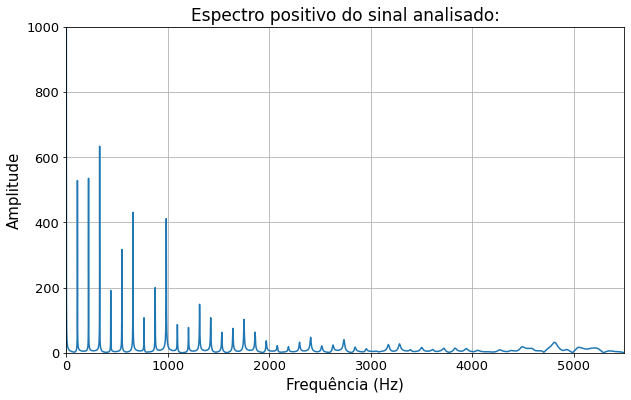

In [ ]:
plot_espectro(sample1,fs,5500)

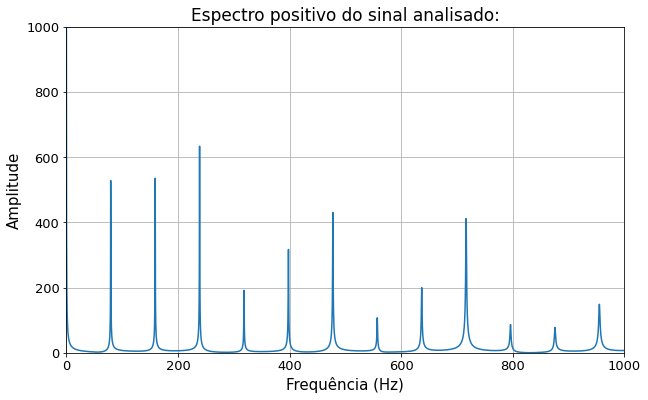

In [ ]:
#zoom nas baixas frequências
plot_espectro(sample1,fs,1000)

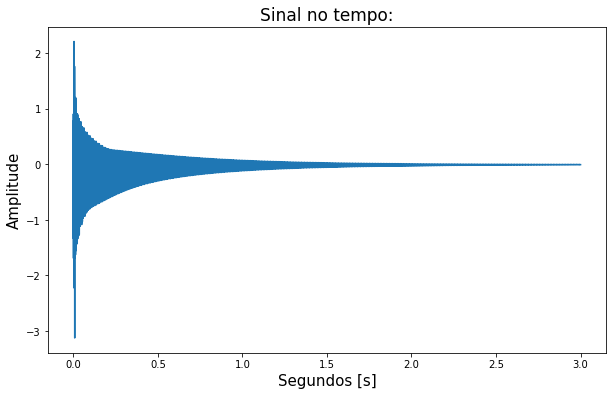

In [ ]:
def plot_tempo(sinal):
    x = np.linspace(0,3,len(sinal))
    plt.figure(figsize=(10,6))
    plt.plot(x,sinal)
    plt.title("Sinal no tempo:", fontsize = 17)
    plt.xlabel("Segundos [s]", fontsize = 15)
    plt.ylabel("Amplitude", fontsize = 15)
    plt.show()

plot_tempo(sample1)


O sinal gerado para a nota lá (110Hz) pode ser comparado com um sinal gerado para a nota mi (82Hz).

Ressaltamos que como $f_s = N \times f$, para o mi temos que $f_s = 8200 Hz$

In [ ]:
#lê arquivo de áudio a partir do drive
nota = drive.CreateFile({'id':'1rpdIJ4I2X2Ew5xvodgoUceNFpW2hgxKX'})
nota.GetContentFile('Nota.wav')

#usando o wavfile 
fs2, nota = wavfile.read('Nota.wav')
print(f"Frequência de amostragem para a nota mi:{fs2} Hz")

ipd.Audio(nota, rate=fs2)

Frequência de amostragem para a nota mi:8200 Hz


## Bônus

Simular um acorde, considerando que os acordes no violão são dados por:

<img src=https://aulasdeviolaoonline.com/wp-content/uploads/2019/04/acordes-maiores-e-menores.jpg>

Fizemos uma função para simular cada nota (dada a frequência da nota, a frequência de amostragem e o tempo de duração). A partir disso pudemos fazer acordes e dedilhados, e também um trecho de música misturando dedilhado e melodia.

In [ ]:
def nota(freq, fs, t, amp=5):
    D = fs // freq
    #input = (amp*np.random.randint(0, 2, D) - 1).astype(np.float)
    L = int(t*fs)
    return karplus_strong_final(L,D)

Acorde de dó

In [ ]:
fs = 8000
atraso = np.zeros(shape=(800,))
corda_1 = nota(82,fs,0.5) #mi
corda_2 = nota(131,fs,0.5) #do
corda_3 = nota(165,fs,0.5) #mi
corda_4 = nota(196,fs,0.5) #sol
corda_5 = nota(262,fs,0.5) #si
corda_6 = nota(330,fs,0.5) #mi

Numa situação ideal em que todas notas soariam juntas, o acorde ficaria:

In [ ]:
acorde = corda_1 + corda_2 + corda_3 + corda_4 + corda_5 + corda_6
ipd.Audio(acorde,rate=fs)

Numa situação mais próxima da real, em que o acorde é dedilhado, uma corda por vez, com um pequeno intervalo entre as notas ele soaria como:

In [ ]:
dedilhado = np.concatenate((corda_1,atraso,corda_2,atraso,corda_3,atraso,corda_4,atraso,corda_5,atraso,corda_6))
ipd.Audio(dedilhado,rate=fs)

Num dedilhado mais usado no violão (baixo + três cordas mais agudas):

In [ ]:
dedilhado2 = np.concatenate((corda_2,atraso,corda_4,atraso,corda_5,atraso,corda_6,atraso,corda_5,atraso,corda_4))
ipd.Audio(dedilhado2,rate=fs)

### Música Hallelujah
Fizemos um trecho de uma música utilizando essa forma de simular notas. Para isso criamos um vetor com as notas da melodia e um com a harmonia (acordes dedilhados) e então os somamos, como se um violão estivesse tocando a melodia e o outro a harmonia.

As notas da melodia tem amplitude maior de forma a se destacar da harmonia.


#### Melodia

In [ ]:
#6 tempos (3s)
re_longo = nota(147,fs,3,20)
do_longo = nota(131,fs,3,20)

#mímina (2s)
sol_m = nota(196,fs,2,20)

#semínima com ponto de aumento (1.5s)
mi_sa = nota(165,fs,1.5,20)
sol_sa = nota(196,fs,1.5,20)
la_sa = nota(220,fs,1.5,20)
do_sa = nota(262,fs,1.5,20)
re_sa = nota(294,fs,1.5,20)

#seminima (1s)
mi_s = nota(165,fs,1,20)
sol_s = nota(196,fs,1,20)
la_s = nota(220,fs,1,20)
si_s = nota(247,fs,1,20)
do_s = nota(262,fs,1,20)
re_s = nota(294,fs,1,20)
mi2_s = nota(330,fs,1,20)

#colcheia (0.5s)
mi_c = nota(165,fs,0.5,20)
fa_c = nota(175,fs,0.5,20)
sol_c = nota(196,fs,0.5,20)
la_c = nota(220,fs,0.5,20)
si_c = nota(247,fs,0.5,20)
do_c = nota(262,fs,0.5,20)
re_c = nota(294,fs,0.5,20)
mi2_c = nota(330,fs,0.5,20)

#pausas
pausa_sa = np.zeros(shape=(12000,))
pausa_s = np.zeros(shape=(8000,))
pausa_c = np.zeros(shape=(4000,))

In [ ]:
melodia = np.concatenate((mi_c,sol_s,sol_c,sol_s,sol_c,la_s,la_c,la_s,mi_c,sol_s,sol_c,sol_s,sol_c,la_s,la_c,la_s,sol_c))
melodia = np.concatenate((melodia,la_sa,la_c,la_c,la_c,la_sa,sol_c,sol_c,fa_c,sol_c,sol_m,pausa_c,pausa_sa,pausa_s,mi_c))
melodia = np.concatenate((melodia,sol_s,sol_c,sol_s,sol_c,la_s,la_c,si_s,si_c,do_s,do_c,do_s,do_c,do_s,do_c,re_s,do_c))
melodia = np.concatenate((melodia,re_s,re_c,re_s,re_c,mi2_s,mi2_c,mi2_s,re_c,re_sa,do_sa,pausa_sa,mi_s,sol_c))
melodia = np.concatenate((melodia,la_sa,la_sa,pausa_sa,la_s,sol_c,mi_sa,mi_sa,pausa_sa,mi_s,sol_c))
melodia = np.concatenate((melodia,la_sa,la_sa,pausa_sa,la_s,sol_c,mi_sa,pausa_c,fa_c,mi_c,re_longo,do_longo))

In [ ]:
ipd.Audio(melodia,rate=fs)

#### Harmonia

In [ ]:
#C
corda_2 = nota(131,fs,0.5) #do
corda_4 = nota(196,fs,0.5) #sol
corda_5 = nota(262,fs,0.5) #do
corda_6 = nota(330,fs,0.5) #mi
acorde_C = np.concatenate((corda_2,corda_4,corda_5,corda_6,corda_5,corda_4))

#Am
corda_2 = nota(110,fs,0.5) #la
corda_4 = nota(220,fs,0.5) #la
corda_5 = nota(262,fs,0.5) #do
corda_6 = nota(330,fs,0.5) #mi
acorde_Am = np.concatenate((corda_2,corda_4,corda_5,corda_6,corda_5,corda_4))

#F
corda_1 = nota(87,fs,0.5) #fa
corda_4 = nota(220,fs,0.5) #la
corda_5 = nota(262,fs,0.5) #do
corda_6 = nota(349,fs,0.5) #fa
acorde_F = np.concatenate((corda_1,corda_4,corda_5,corda_6,corda_5,corda_4))
acorde_F_curto = np.concatenate((corda_4,corda_5,corda_6))

#G
corda_1 = nota(98,fs,0.5) #sol
corda_4 = nota(196,fs,0.5) #sol
corda_5 = nota(294,fs,0.5) #re
corda_6 = nota(392,fs,0.5) #sol
acorde_G = np.concatenate((corda_1,corda_4,corda_5,corda_6,corda_5,corda_4))
acorde_G_curto = np.concatenate((corda_4,corda_5,corda_6))

#Em
corda_1 = nota(82,fs,0.5) #do
corda_4 = nota(196,fs,0.5) #sol
corda_5 = nota(247,fs,0.5) #si
corda_6 = nota(330,fs,0.5) #mi
acorde_Em = np.concatenate((corda_1,corda_4,corda_5,corda_6,corda_5,corda_4))

#E
corda_1 = nota(82,fs,0.5) #do
corda_4 = nota(208,fs,0.5) #sol#
corda_5 = nota(247,fs,0.5) #si
corda_6 = nota(330,fs,0.5) #mi
acorde_E = np.concatenate((corda_1,corda_4,corda_5,corda_6,corda_5,corda_4))

In [ ]:
harmonia = np.concatenate((pausa_c,acorde_C,acorde_Am,acorde_C,acorde_Am,acorde_F,acorde_G,acorde_C,acorde_G))
harmonia = np.concatenate((harmonia, acorde_C,acorde_F_curto,acorde_G_curto,acorde_Am,acorde_F,acorde_Em,acorde_E,acorde_Am,acorde_Am))
harmonia = np.concatenate((harmonia, acorde_F,acorde_F,acorde_Am,acorde_Am,acorde_F,acorde_F,acorde_C,acorde_G,acorde_C))

In [ ]:
ipd.Audio(harmonia,rate=fs)

#### Final

In [ ]:
musica = melodia + harmonia
ipd.Audio(musica,rate=fs)